# Data Analysis of Metabolomics on Liver Tissue - Machine Learning
## Purpose
Metabolomics was performed on liver tissue homogenate from mice that were considered sick or healthy controllers following infection. Our goal is to identify which metabolites were enriched in one population and not the other by using Machine learning/data science techniques

## Principal Component Analysis (PCA)
To explore the clinical data, PCA was used. PCA is a statistical tool and dimensionality-reduction method that helps identify and visualizes potential relationships between clinical data and the 917 metabolites. PCA increases interpretability but at the same time minimizes information loss. It does so by creating new uncorrelated variables that successively maximize variance. By Converting correlations into a 2-D graph, the correlated groups will cluster together. 



In [1]:
# Libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors 
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# read in dfs 
merged_data = pd.read_csv("../raw/final_merged_jeren.csv")
names = pd.read_csv("../raw/Biochemical_names.csv")
metab_def = pd.read_csv("../raw/metabolite_definitions.csv")

In [3]:
metabolites = [col for col in merged_data.columns if 'X' in col]
# Separating out the features (ie metabolites)
x = merged_data.loc[:, metabolites].values
# Separating out the Group
y = merged_data.loc[:,['Group']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [4]:
# Create definition to take in the metabolite index and return the biochemical name
def lookup_ChemID_to_Biochemical(chemID):
    # remove the prefix "x" if present
    chemID = chemID.replace('X','')
    biochem_name = names.loc[names['CHEMICAL ID'] == int(chemID), 'BIOCHEMICAL'].iloc[0]
    return biochem_name

In [5]:
# Revise the merged_data dataframe to include Survivor (0)/Non-survivor status (1)
def label_survivorStatus(row):
    if 'H' in row.Group:
        #survivor
        return 0
    elif 'S' in row.Group:
        # non-survivor
        return 1

merged_data['Status']=merged_data.apply(label_survivorStatus, axis=1)
merged_data.head()

,Unnamed: 0,parent_sample_name,Group,CLIENT_IDENTIFIER,PARAM_AGE,PARAM_ANIMAL_ID,PARAM_CLIENT_SAMPLE_ID,PARAM_GENDER,PARAM_GROUP_ID,HPI.Sacced,...,X100001451,X566,X100003640,X100003641,X100003210,X1004,X100000299,X100000015,year,Status
0,1,HARV-24509,EH_WT,EH5,8w,12.7.18_#7,Early healthy WT,M,EH_WT,60,...,1.0257,0.6015,1.1362,1.0880,0.9940,0.9168,1.2714,1.2557,2018,0.0
1,2,HARV-24510,EH_WT,EH7,8w,12.7.18_#11,Early healthy WT,F,EH_WT,60,...,1.5438,0.8071,0.7525,0.7213,1.3981,1.0934,1.5455,0.8756,2018,0.0
2,3,HARV-24511,EH_WT,EH9,6w,2.1.19_#6,Early healthy WT,M,EH_WT,46,...,1.0104,0.4416,1.0011,0.9842,0.6383,0.9799,1.8851,0.7286,2019,0.0
3,4,HARV-24512,EH_WT,EH11,7w,6.11.19_#7,Early healthy WT,F,EH_WT,57,...,0.8915,0.6896,0.5123,0.6470,0.9666,0.8868,0.5241,0.6401,2019,0.0
4,5,HARV-24514,ES_WT,ES4,8w,12.7.18_#14,Early sick WT,F,ES_WT,60,...,1.2712,0.9087,1.6988,1.2799,1.2191,1.4242,3.6886,0.3365,2018,1.0


# Principal Component Analysis

In [6]:
# Perform PCA analysis
pca3d = PCA(n_components=3)
principalComponents_3d = pca3d.fit_transform(x)
print(pca3d.explained_variance_ratio_)


##### Record the loadings from the PCA analysis
# Principal components correlation coefficients
loadings = pca3d.components_

# Number of features before PCA
n_features = pca3d.n_features_in_
print(n_features)

# Feature names before PCA
feature_names = [lookup_ChemID_to_Biochemical(x) for x in metabolites]

# # PC names
df_loadings = pd.DataFrame(pca3d.components_.T*np.sqrt(pca3d.explained_variance_), columns=['PC1', 'PC2','PC3'], index=feature_names)
df_loadings['Magnitude'] = np.sqrt(df_loadings.PC1**2+df_loadings.PC2**2+df_loadings.PC3**2)
df_loadings = df_loadings.sort_values(by='Magnitude',ascending=False)
df_loadings.to_csv('../processed_v2/df_PCA3D-Loadings.csv')

##### Construct PCA dataframe that also contains the clinical info of the mice
df_PCA3D = pd.DataFrame(data = principalComponents_3d,
                           columns = ['PC 1','PC 2','PC 3'])

df_PCA3D = pd.concat([df_PCA3D, merged_data[['PARAM_GENDER']], merged_data[['Group']]], axis = 1)
df_PCA3D.to_csv('../processed_v2/df_PCA3D.csv')
df_PCA3D.head()

[0.28085053 0.10605596 0.0711923 ]
917


,PC 1,PC 2,PC 3,PARAM_GENDER,Group
0,16.233331,-2.375186,-7.967433,M,EH_WT
1,16.860422,8.804166,3.027698,F,EH_WT
2,22.786636,-7.776664,-4.460614,M,EH_WT
3,-0.159236,-5.954851,-0.553870,F,EH_WT
4,-4.770076,1.571618,-3.923753,F,ES_WT


C:\Users\Aditya\AppData\Local\Temp\ipykernel_36824\4151286703.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


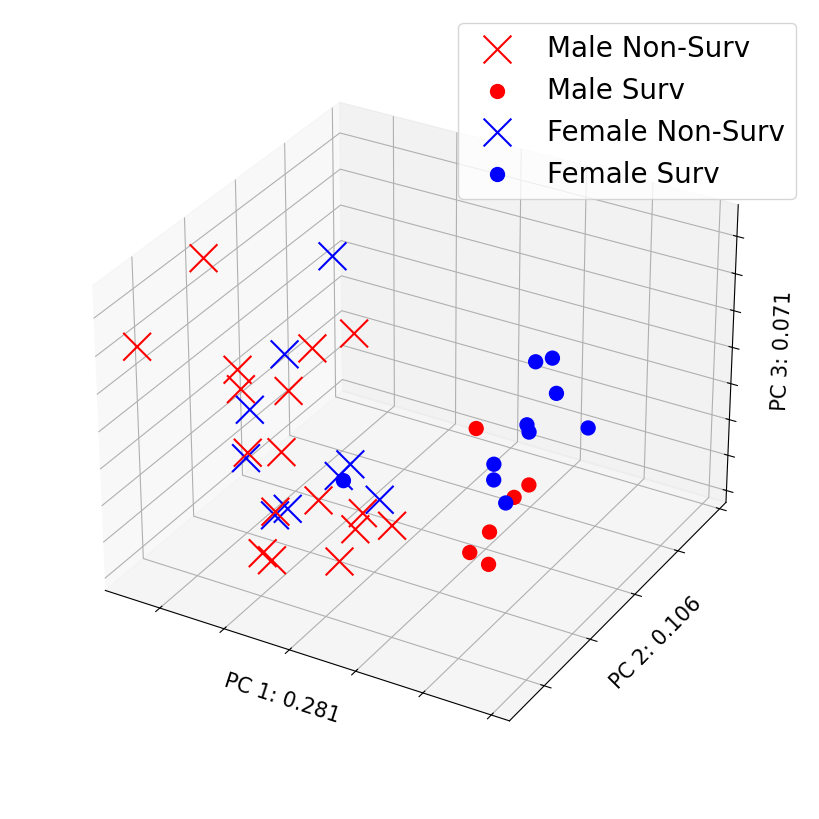

In [7]:
#double check to see proportion of sick vs healthy by sex of mice 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (8,8))
ax = Axes3D(fig)
fig.add_axes(ax)
ax.set_xlabel('PC 1: {}'.format(round(pca3d.explained_variance_ratio_[0],3)), fontsize = 15)
ax.set_ylabel('PC 2: {}'.format(round(pca3d.explained_variance_ratio_[1],3)), fontsize = 15)
ax.set_zlabel('PC 3: {}'.format(round(pca3d.explained_variance_ratio_[2],3)), fontsize = 15)
# ax.set_title('2 Component PCA', fontsize = 20)

PARAM_GENDERS = ['M','M','F','F']
PARAM_GROUP = ['S','H','S','H']
Groups = ['Male Non-Surv','Male Surv','Female Non-Surv','Female Surv']

colors = ['r', 'r','b','b']
markers = ['x','.', 'x', '.']

for i in range(len(Groups)):
    Gender = PARAM_GENDERS[i]
    Group = PARAM_GROUP[i]
    Color = colors[i]
    Marker = markers[i]
    
    indicesToKeep = (df_PCA3D['PARAM_GENDER'] == Gender)&(df_PCA3D['Group'].str.contains(Group))
    ax.scatter(df_PCA3D.loc[indicesToKeep, 'PC 1'], df_PCA3D.loc[indicesToKeep, 'PC 2'],
               df_PCA3D.loc[indicesToKeep, 'PC 3']
               , c = Color
               , s = 400
               , marker = Marker
               , label = Groups[i], alpha=1)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.legend(prop={'size':20})#,bbox_to_anchor=(1.3,1.05))
ax.grid()
ax.set_box_aspect(aspect=None, zoom=0.9) 
# ax.view_init(45,45)
plt.tight_layout()
plt.savefig('../processed_v2/PCA_3d_Gender_SickvsHealthy.png')
plt.show()

Similar to the previous graph, there is clear separation and group between the sick and healthy mice. The sick mice as shown by the x-shaped markers group to the left, whereas the healthy mice as shown by the dots group towards the right. There appears to be no strong grouping by sex, there is slight grouping with healthy male mice on the bottom right. 


## PCA Loadings Plot
Let's examine what are the important features that are leading to this separation, perhaps the top 15

0
lactate
1
urea
2
sulfate*
3
glutathione, reduced (GSH)
4
N,N-dimethyl-pro-pro
5
itaconate
6
alpha-hydroxyisovalerate
7
dimethylarginine (ADMA + SDMA)
8
myristoleate (14:1n5)
9
gamma-glutamylcysteine
10
alanine
11
phosphoethanolamine (PE)
12
glucose


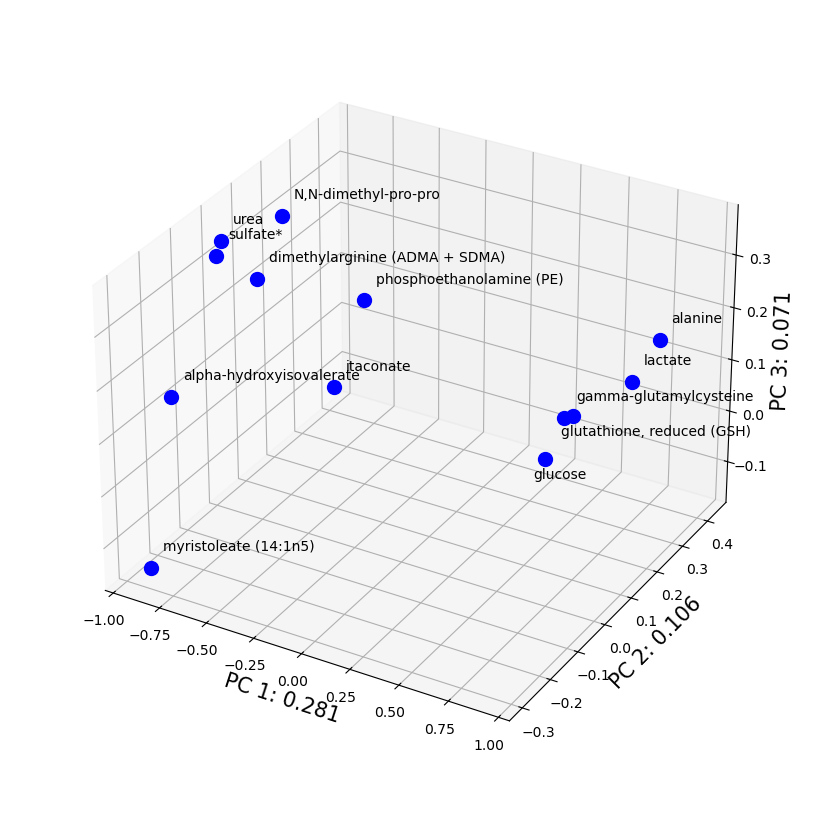

In [8]:
# sort the df_loadings dataframe by magnitude and choose to visualize the top 15 features
num_features = 13
offset = 0.025

fig = plt.figure(figsize = (8,8))
ax = Axes3D(fig)
fig.add_axes(ax)
ax.set_xlabel('PC 1: {}'.format(round(pca3d.explained_variance_ratio_[0],3)), fontsize = 15)
ax.set_ylabel('PC 2: {}'.format(round(pca3d.explained_variance_ratio_[1],3)), fontsize = 15)
ax.set_zlabel('PC 3: {}'.format(round(pca3d.explained_variance_ratio_[2],3)), fontsize = 15)
# Annotate each of the scatter points with the feature name
for i in range(num_features):
    print(i)
    ax.scatter(df_loadings.iloc[i, 0],
           df_loadings.iloc[i, 1],
           df_loadings.iloc[i, 2],
           s = 100,alpha=1,color='blue')
    print(df_loadings.index[i])
    if (i == 3) or (i == 12):
        ax.text(df_loadings.iloc[i, 0]-offset,df_loadings.iloc[i, 1]-offset, df_loadings.iloc[i, 2]-offset, 
                '%s' % (df_loadings.index[i]), size=10, zorder=1,color='k') 
    else:
        ax.text(df_loadings.iloc[i, 0]+offset,df_loadings.iloc[i, 1]+offset, df_loadings.iloc[i, 2]+offset, 
                '%s' % (df_loadings.index[i]), size=10, zorder=1,color='k') 

# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
ax.grid()
ax.set_box_aspect(aspect=None, zoom=0.9) 
# ax.view_init(45,45)
# plt.tight_layout()
plt.savefig('../processed_v2/PCA_3d_loadings.png')
plt.show()

The above graph shows the loadings plot of the top 13 metabolites driving variance in the PCA. We can see that the survivors are enriched in glucose and glutathione products whereas the non-survivors are enriched in intermediates of cyclical processes like urea, N,N-dimethyl-pro-pro, itaconate, etc

# Classification
Let's see whether we can use machine learning approaches to classify the mice to survival/non-survival status. Let's use the following approaches:
1. Logistic Regression
3. Random Forest
4. Support Vector Machine
5. K-nearest classifier
6. Gradient Boosting classifier

Because of a class imbalance between survivors and non-survivors, make sure to stratify the data during the train/test split to make sure comparable numbers of each class are part of the training. Reserve 30% of the data for testing

In [9]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score

### Create feature matrix and target matrix
metabolites = [col for col in merged_data.columns if 'X' in col]
# remove any rows with NA values and separating out the features (ie metabolites)
merged_data2 = merged_data.dropna()
X = merged_data2.loc[:, metabolites].values
y = merged_data2.Status
print([X.shape, y.shape])
# Split data into test-train splits
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

### Constructing classification workflow
# Construct different classifiers 
clfs = []
clfs.append(LogisticRegression())
clfs.append(SVC())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs.append(RandomForestClassifier())
clfs.append(GradientBoostingClassifier())

# initialize pipeline
pipeline = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('clf', LogisticRegression()) #step2 - classifier
])



[(42, 917), (42,)]
(29, 917)
(13, 917)
(29,)
(13,)


In [10]:
# test the different classifiers
results_testScore_Mean = []
results_testScore_Std = []
for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, X_train, y_train) # default 5-fold cross validation
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())
            if key == 'test_score':
                results_testScore_Mean.append(values.mean())
                results_testScore_Std.append(values.std())

---------------------------------
LogisticRegression()
-----------------------------------
fit_time  mean  0.014739799499511718
fit_time  std  0.004446252729727004
score_time  mean  0.002157735824584961
score_time  std  0.00020857575704641215
test_score  mean  0.9666666666666668
test_score  std  0.06666666666666665
---------------------------------
SVC()
-----------------------------------
fit_time  mean  0.0038019657135009766
fit_time  std  0.0009929734264363208
score_time  mean  0.0020238876342773436
score_time  std  0.0006180030949771712
test_score  mean  0.9666666666666668
test_score  std  0.06666666666666665
---------------------------------
KNeighborsClassifier(n_neighbors=3)
-----------------------------------
fit_time  mean  0.0027514934539794923
fit_time  std  0.0007496896916264393
score_time  mean  0.1309051036834717
score_time  std  0.1336853936004216
test_score  mean  0.9333333333333333
test_score  std  0.08164965809277258
---------------------------------
RandomForestClass

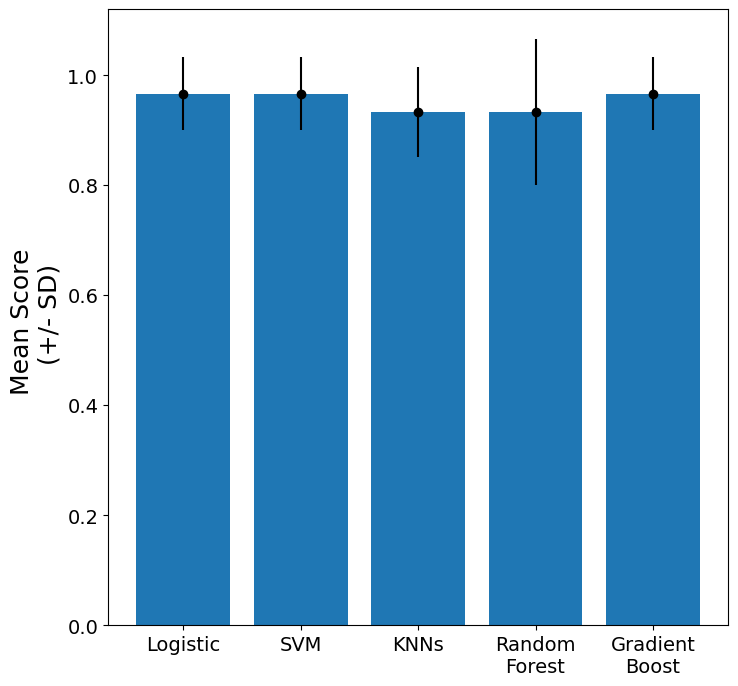

In [11]:
# Visualize the performance of each of the classifiers
labels_clf = ['Logistic','SVM','KNNs','Random\nForest','Gradient\nBoost']
fig = plt.figure(figsize = (8,8))
plt.bar(range(len(results_testScore_Mean)), results_testScore_Mean)
plt.errorbar(range(len(results_testScore_Mean)), results_testScore_Mean, yerr=results_testScore_Std, fmt="o",color="k")
plt.xticks(range(len(labels_clf)), labels_clf,fontsize=14)
plt.ylabel('Mean Score \n (+/- SD)',fontsize=18)
plt.yticks(fontsize=14)
plt.show()

Based on the results from these 5 regression models, the logistic regression had the best classification performance. As such, let's examine the precision/recall, confusion matrix, and ROC curve of the logistic regression method

In [12]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc, accuracy_score
import seaborn as sns

lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.9230769230769231
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89         5
         1.0       0.89      1.00      0.94         8

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



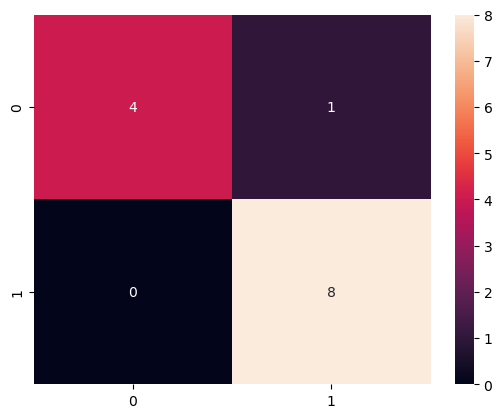

In [13]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
plt.savefig('../processed_v2/plotCLF_LR_ConfusionMatrix.png')
plt.show()

In [14]:
# Let's visualize the ROC curve, which plots true positive rate against false positive rate at different threshold values.
y_predprob=lr.predict_proba(X_test)
fpr,tpr,threshold = roc_curve(y_test,y_predprob[:,1]) #target 1 probability, or non-survivor status
auc_val = auc(fpr,tpr)

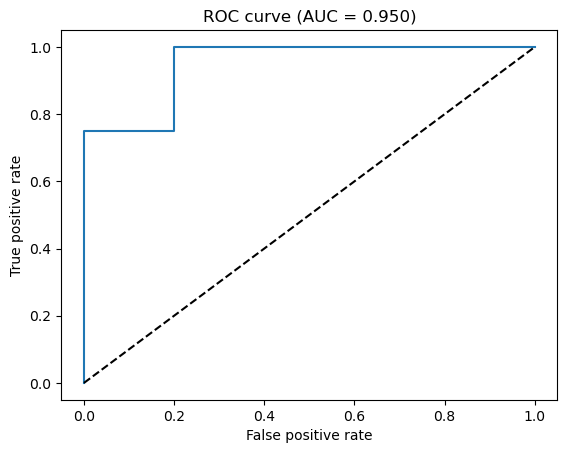

In [15]:
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (AUC = {:.3f})'.format(auc_val))
plt.savefig('../processed_v2/plotCLF_LR_ROC.png')
plt.show()

In [16]:
### Determine feature importance
# Coefficients and Odds Ratios
coefficients = lr.coef_[0]
odds_ratios = np.exp(coefficients)

# Display feature importance using coefficients and odds ratios
df_LR_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios,
    'Abs_Coeff': np.abs(coefficients)
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(df_LR_feature_importance.sort_values(by='Abs_Coeff', ascending=False))


Feature Importance (Coefficient and Odds Ratio):
                          Feature  Coefficient  Odds Ratio  Abs_Coeff
576                   maltotriose    -0.099037    0.905709   0.099037
852     succinylcarnitine (C4-DC)    -0.072959    0.929639   0.072959
235         4-ethylphenyl sulfate    -0.063997    0.938008   0.063997
884               trans-urocanate    -0.062218    0.939678   0.062218
414                 equol sulfate    -0.059468    0.942266   0.059468
..                            ...          ...         ...        ...
313                     aspartate    -0.000208    0.999792   0.000208
903  uridine 5'-diphosphate (UDP)     0.000166    1.000166   0.000166
222             3-indoxyl sulfate    -0.000162    0.999838   0.000162
913                  valylleucine     0.000144    1.000144   0.000144
365                      cysteine     0.000007    1.000007   0.000007

[917 rows x 4 columns]


In summary, the logistic regression model performed equally well with SVM and Gradient Boost but we chose to further investigate logistic regression model due to its simplicity. We found that with cross-validation it had a mean score of 0.96, had great recall of 1.0 on the test-dataset for the non-survivors, and an AUC of 0.95. This shows that it has great classification performance. 

# Classification using Data transformed to PCA
Given the nice clusters PCA gives, repeat the classification workflow on the data transformed to the PC space

In [17]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

### Create feature matrix and target matrix
metabolites = [col for col in merged_data.columns if 'X' in col]
# remove any rows with NA values and separating out the features (ie metabolites)
merged_data2 = merged_data.dropna()
X = merged_data2.loc[:, metabolites].values
y = merged_data2.Status
print([X.shape, y.shape])
# Split data into test-train splits
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

### Constructing classification workflow
# Construct different classifiers 
clfs = []
clfs.append(LogisticRegression())
clfs.append(SVC())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs.append(RandomForestClassifier())
clfs.append(GradientBoostingClassifier())

# initialize pipeline
pipeline2 = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('PCtransform',PCA(n_components=3)), #Step2 - PCA transform
    ('clf', LogisticRegression()) #step2 - classifier
])


[(42, 917), (42,)]
(33, 917)
(9, 917)
(33,)
(9,)


In [18]:
# test the different classifiers
results_testScore_Mean = []
results_testScore_Std = []
for classifier in clfs:
    pipeline2.set_params(clf = classifier)
    scores = cross_validate(pipeline2, X_train, y_train) # default 5-fold cross validation
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())
            if key == 'test_score':
                results_testScore_Mean.append(values.mean())
                results_testScore_Std.append(values.std())


---------------------------------
LogisticRegression()
-----------------------------------
fit_time  mean  0.012985944747924805
fit_time  std  0.0010197175616598788
score_time  mean  0.001847219467163086
score_time  std  0.00037269454407217286
test_score  mean  0.9666666666666668
test_score  std  0.06666666666666665
---------------------------------
SVC()
-----------------------------------
fit_time  mean  0.008578348159790038
fit_time  std  0.001547391236607998
score_time  mean  0.0017966270446777345
score_time  std  0.0003998615959315661
test_score  mean  0.9666666666666668
test_score  std  0.06666666666666665
---------------------------------
KNeighborsClassifier(n_neighbors=3)
-----------------------------------
fit_time  mean  0.0070896148681640625
fit_time  std  0.0009008863494300331
score_time  mean  0.004275369644165039
score_time  std  0.0008732463714339175
test_score  mean  0.9666666666666668
test_score  std  0.06666666666666665
---------------------------------
RandomForestC

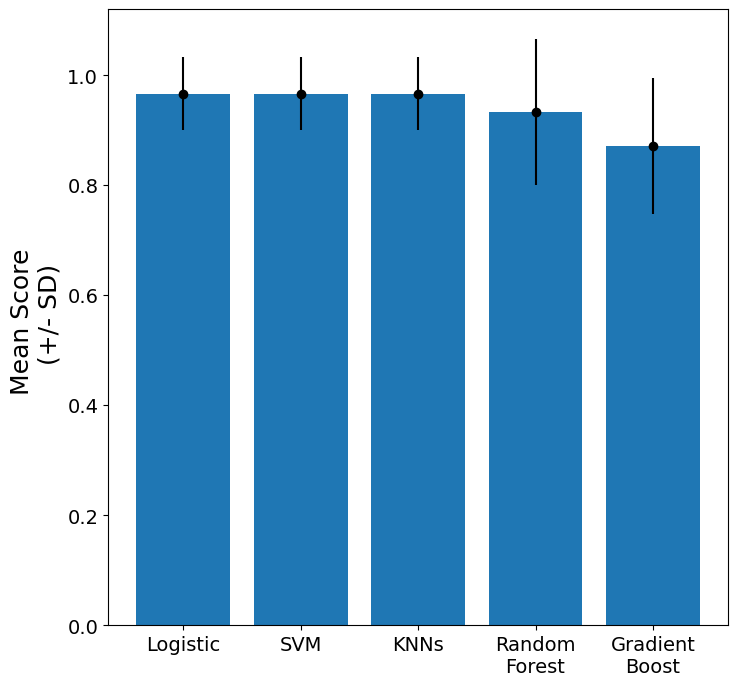

In [19]:
# Visualize the performance of each of the classifiers
labels_clf = ['Logistic','SVM','KNNs','Random\nForest','Gradient\nBoost']
fig = plt.figure(figsize = (8,8))
plt.bar(range(len(results_testScore_Mean)), results_testScore_Mean)
plt.errorbar(range(len(results_testScore_Mean)), results_testScore_Mean, yerr=results_testScore_Std, fmt="o",color="k")
plt.xticks(range(len(labels_clf)), labels_clf,fontsize=14)
plt.ylabel('Mean Score \n (+/- SD)',fontsize=18)
plt.yticks(fontsize=14)
plt.savefig('../processed_v2/plot_CLFpipeline_PCA-Xtrain.png')
plt.savefig('../processed_v2/plot_CLFpipeline_PCA-Xtrain.pdf')
plt.show()

Again, logistic regression gave great classification performance on the PCs. Let's see the ROC curves

In [20]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc, accuracy_score
import seaborn as sns

# initialize pipeline
pipeline3 = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('PCtransform',PCA(n_components=3)), #Step2 - PCA transform
    ('clf', LogisticRegression()) #step2 - classifier
])

pipeline3.fit(X_train,y_train)
y_pred = pipeline3.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

# Let's visualize the ROC curve, which plots true positive rate against false positive rate at different threshold values.
y_predprob=pipeline3.predict_proba(X_test)
fpr,tpr,threshold = roc_curve(y_test,y_predprob[:,1]) #target 1 probability, or non-survivor status
auc_val = auc(fpr,tpr)

1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



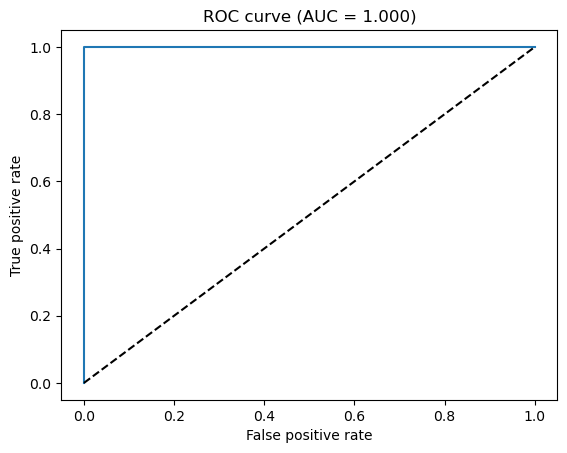

In [21]:
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (AUC = {:.3f})'.format(auc_val))
plt.savefig('../processed_v2/plotCLF_LR_PCA.png')
plt.savefig('../processed_v2/plotCLF_LR_PCA.pdf')
plt.show()

# Regression
## Method 1 (Multiple Linear Regression): Univariate Correlation Feature Selection using Final Temperature as Response Variable
 
Univariate correlation feature selection was used to identify specific metabolites that contribute the most to the predictive model. Correlation feature selection pinpoints the variables(in this case specific metabolites) with the highest correlation coefficients and therefore the metabolites that contribute the most to predicting the clincial feature (which in this case is temperature). 


In [40]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, chi2, f_regression

#Creating target variable
y = np.array(merged_data['Final_Temp'])
#Create feature variables (metabolites)
metabolites = [col for col in merged_data.columns if 'X' in col]
# Separating out the features (ie metabolites)
df_metabs = merged_data.loc[:, metabolites]
x = merged_data.loc[:, metabolites].values

# Create dictionaries to go from chemID to biochemical, subpathways
dict_chemID_BIOCHEMICAL = dict(zip(metab_def['CHEMICAL ID'],metab_def['BIOCHEMICAL']))
dict_chemID_SUBPATHWAY = dict(zip(metab_def['CHEMICAL ID'],metab_def['SUB PATHWAY']))


In [41]:
#Fitting data into model and transforming, while selecting largest k values with f_regression as score function 
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(x,y)
Feature_corr = pd.DataFrame(data={'CHEMICAL ID': np.ravel(df_metabs.columns), 
                                   'feature_corrVal': fs.scores_,
                                 'feature_pVal': fs.pvalues_})
Feature_corr['CHEMICAL ID'] = Feature_corr['CHEMICAL ID'].str.replace('X','').astype(int)
# Feature_corr.head()

#Add metabolite names as new column
Feature_corr['BIOCHEMICAL'] = Feature_corr['CHEMICAL ID'].map(dict_chemID_BIOCHEMICAL)
Feature_corr['Pathway'] = Feature_corr['CHEMICAL ID'].map(dict_chemID_SUBPATHWAY)

# Feature_corr.head()

# Renaming and organizing by descending order
Feature_corr = Feature_corr.sort_values(by='feature_corrVal',ascending=False).reset_index(drop=True)
print(Feature_corr.head(20).Pathway.value_counts())
Feature_corr.head(20)

Pathway
Leucine, Isoleucine and Valine Metabolism          7
Phospholipid Metabolism                            2
Fatty Acid, Dihydroxy                              1
Food Component/Plant                               1
Fatty Acid, Monohydroxy                            1
Long Chain Monounsaturated Fatty Acid              1
Histidine Metabolism                               1
Glycine, Serine and Threonine Metabolism           1
Phosphatidylethanolamine (PE)                      1
Folate Metabolism                                  1
Fatty Acid Metabolism (Acyl Carnitine, Hydroxy)    1
Fatty Acid, Dicarboxylate                          1
Mevalonate Metabolism                              1
Name: count, dtype: int64


,CHEMICAL ID,feature_corrVal,feature_pVal,BIOCHEMICAL,Pathway
0,100001300,125.331930,4.821470e-14,alpha-hydroxyisovalerate,"Leucine, Isoleucine and Valine Metabolism"
1,100002284,97.917767,1.996398e-12,"2S,3R-dihydroxybutyrate","Fatty Acid, Dihydroxy"
2,100001541,97.838397,2.020152e-12,2-hydroxy-3-methylvalerate,"Leucine, Isoleucine and Valine Metabolism"
3,100002417,86.085153,1.261592e-11,"2,3-dihydroxyisovalerate",Food Component/Plant
4,1442,83.609523,1.896668e-11,beta-hydroxyisovalerate,"Leucine, Isoleucine and Valine Metabolism"
5,100001143,82.642781,2.229005e-11,3-hydroxysuberate,"Fatty Acid, Monohydroxy"
6,100001198,80.569884,3.164901e-11,myristoleate (14:1n5),Long Chain Monounsaturated Fatty Acid
7,100004299,77.726242,5.170949e-11,N-acetyl-1-methylhistidine*,Histidine Metabolism
8,1084,76.180574,6.786592e-11,N-acetylvaline,"Leucine, Isoleucine and Valine Metabolism"
9,100015666,74.160582,9.736051e-11,glycerophosphoserine*,Phospholipid Metabolism


The above table presents the 20 metabolites with the highest Feature scores. The table includes the chemical ID number, feature score, and its corresponding biochemical name. 

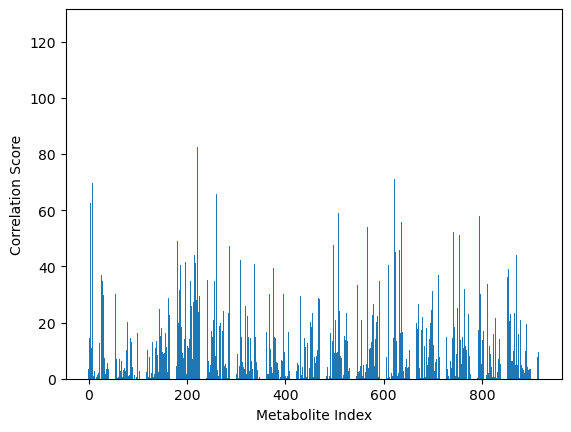

In [42]:
#plot the scores
plt.figure()
plt.bar(range(len(fs.scores_)), fs.scores_)
plt.xlabel('Metabolite Index')
plt.ylabel('Correlation Score')
plt.show()


The above graph plots the metabolite number (as shown by the x-axis) and the feature score (as shown in the y axis). The peaks represent metabolites with particularly high feature scores. A higher feature score indicates that the variable contributes more to accurately predicting the desired clinical outcome.  


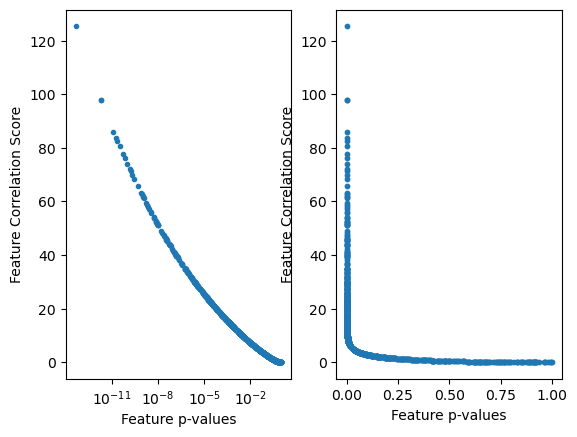

In [43]:
#plot the scores vs p-value
fig, axs = plt.subplots(nrows=1,ncols=2) 
axs[0].semilogx(fs.pvalues_, fs.scores_,marker='.',linestyle='')
axs[0].set_xlabel('Feature p-values')
axs[0].set_ylabel('Feature Correlation Score')
axs[1].scatter(fs.pvalues_, fs.scores_,s=10)
axs[1].set_xlabel('Feature p-values')
axs[1].set_ylabel('Feature Correlation Score')

plt.show()


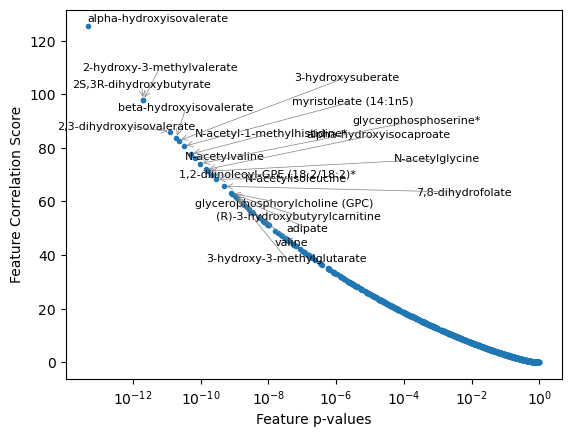

In [52]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Create the plot
plt.figure()
plt.semilogx(Feature_corr.feature_pVal, Feature_corr.feature_corrVal, marker='.', linestyle='')
plt.xlabel('Feature p-values')
plt.ylabel('Feature Correlation Score')

# Annotate the top 20 points
texts = []
for idx in range(20):
    x, y = Feature_corr.feature_pVal.iloc[idx], Feature_corr.feature_corrVal.iloc[idx]  # Use .iloc to avoid indexing issues
    label = Feature_corr.iloc[idx]['BIOCHEMICAL']
    text = plt.text(x, y, label, fontsize=8)
    texts.append(text)

# Adjust text to push labels downward and prevent overlap
adjust_text(
    texts,
    expand=(1.2, 1.4),  # Give space for better placement
    force_points=(0.1, 0.3),  # Push labels downward
    force_text=(0.2, 0.4),  # Further push labels down and left
    only_move={'points': 'y', 'text': 'xy'},  # Keeps arrows clean
    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5)  # Lighter, more readable arrows
)
plt.savefig('../processed/plot_UnivCorr-Features_annotated.png')
plt.show()


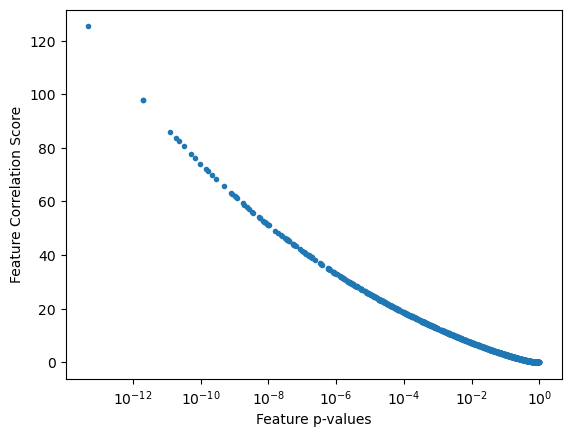

In [54]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Create the plot
plt.figure()
plt.semilogx(Feature_corr.feature_pVal, Feature_corr.feature_corrVal, marker='.', linestyle='')
plt.xlabel('Feature p-values')
plt.ylabel('Feature Correlation Score')

plt.savefig('../processed/plot_UnivCorr-Features_unannotated.png')
plt.savefig('../processed/plot_UnivCorr-Features_unannotated.pdf')
plt.show()


Now, we want to see whether we can obtain a strong predictive model of final temperature using a reduced set of metabolites. So, we created a Multiple Linear Regression Model using only the 20 metabolites with the highest feature selection score to determine how well the metabolites correlate and predict the desired clinical outcome (temperature).

Workflow: We will first select the features of interest as identified by univariate correlation and assemble a new features matrix with them. We will then perform K-Fold cross validation to evaluate how multiple linear regression performs with these selected features. We will then generate a new multiple linear regression model instance trained on 80% of the data and tested on 20% and visualize how well the predicted values are from the actual values

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Define number of metabolites to use for the regression
num_metabs = 20

# Assemble data table using the top chosen metabs
chosenMetabChemID = Feature_corr['CHEMICAL ID'].values[:num_metabs]
chosenMetabChemID = ['X'+str(s) for s in chosenMetabChemID]
print(chosenMetabChemID)
print(len(chosenMetabChemID))

# Extract response variable (final temp)
y = np.array(merged_data['Final_Temp'])
print(y.shape)
# Create matrix of selected features
x = np.array(df_metabs.loc[:,chosenMetabChemID])
print(x.shape)



['X100001300', 'X100002284', 'X100001541', 'X100002417', 'X1442', 'X100001143', 'X100001198', 'X100004299', 'X1084', 'X100015666', 'X100000706', 'X100001006', 'X100009217', 'X100001276', 'X173', 'X100000269', 'X100003926', 'X100000863', 'X566', 'X112']
20
(43,)
(43, 20)


In [26]:
# Define cross-validation method
cv = KFold(n_splits=5, random_state=1,shuffle=True)

# Build multiple linear regression model
model = LinearRegression()

# Use K-fold CV to evaluate model
scores = cross_val_score(model, x, y,
                         scoring='neg_mean_squared_error',
                        cv=cv, n_jobs=1)
# output scores
print(scores)
# Print out the square root of the Mean Squared Error (MSE) 
# for RMSE. 
print('Average RMSE = {}'.format(np.sqrt(np.mean(np.abs(scores)))))
print('Std. Dev of RMSE = {}'.format(np.sqrt(np.std(scores))))

[-13.06130764 -13.43563912  -7.1234809   -3.91519132  -6.12997124]
Average RMSE = 2.9551849425376826
Std. Dev of RMSE = 1.9575863653627696


In [27]:
# Perform train-test split for visualization purposes 
# of multiple linear regression on the features as identified by
# univariate correlation
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size=0.2,
                                                   random_state=4)
print(x_train.shape)
model = LinearRegression().fit(x_train,y_train)
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

(34, 20)


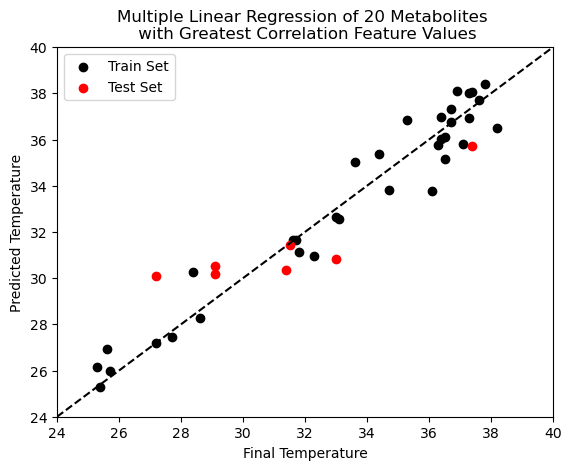

In [28]:
#plotting 
plt.scatter(y_train, y_train_pred,  color='black',label='Train Set')
plt.scatter(y_test, y_test_pred,  color='red',label='Test Set')

plt.title('Multiple Linear Regression of 20 Metabolites \n with Greatest Correlation Feature Values')
plt.xlabel('Final Temperature') 
plt.ylabel('Predicted Temperature')
# plot diagonal identity line
plt.xlim(24,40)
plt.ylim(24,40)
plt.plot(np.linspace(24,40,100),np.linspace(24,40,100),'k--')
plt.legend()
plt.savefig('../processed_v2/plotReg_MLR-UnivCorr_trainTest.png')
plt.savefig('../processed_v2/plotReg_MLR-UnivCorr_trainTest.pdf')
plt.show()

The graph plots the predicted temperature (y) and the actual final temperature of the mice (x). As shown in the graph above, the multiple linear regression model shows a clear linear relationship. The blue line delineates and emphasizes the linear relationship. This means that we have strong predictive performance of temperature using 20 of the 917 metabolites

In [29]:
# Determine coefficients value and confidence interval using sm
import statsmodels.api as sm
alpha = 0.05 # 95% confidence interval
lr = sm.OLS(y_train, sm.add_constant(x_train)).fit()
conf_interval = lr.conf_int(alpha)
# print(conf_interval)
df_MLR_Univ = pd.DataFrame({'Metabolite':Feature_corr.BIOCHEMICAL[:num_metabs+1],
                            'Coefficients':lr.params,'lower':conf_interval[:,0],
                            'upper':conf_interval[:,1],'pvalues':lr.pvalues}).sort_values(by='Coefficients',ascending=False).reset_index(drop=True)
df_MLR_Univ.head()

,Metabolite,Coefficients,lower,upper,pvalues
0,alpha-hydroxyisovalerate,38.797329,30.438924,47.155734,1.742166e-07
1,"2,3-dihydroxyisovalerate",5.625371,-2.517712,13.768453,1.594560e-01
2,3-hydroxy-3-methylglutarate,4.352128,-1.123268,9.827525,1.096605e-01
3,"1,2-dilinoleoyl-GPE (18:2/18:2)*",1.866002,-5.983557,9.715561,6.161734e-01
4,2-hydroxy-3-methylvalerate,1.597253,-0.779521,3.974027,1.702546e-01


## Method 2 (Multiple Linear Regression): Using LASSO Regularization with Final Temperature as Response Variable
Lasso is supervised regression analysis tool selection tool that performs both regularization and feature selection. In Lasso, the loss function is modified to minimize the complexity of the model by limiting the sum of the absolute values of the model coefficients. Hence, LASSO is very conservative when it comes to ruling in metabolites into the model it constructs. Ultimately, LASSO identifies metabolites that are particuarly useful for predicting the clinical data. 

In [30]:
#LASSO Analysis 
# Import Libraries
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LinearRegression
#Defining Variables:
y = np.array(merged_data['Final_Temp'])
x = np.array(df_metabs)
print(x.shape)

(43, 917)


In [31]:
#Pipeline Scaling
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])
#Optimize alpha-hyperparameter
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",
                      verbose=0)
#Fit the grid search
search = search.fit(x,y)
#Get best alpha
search_alpha = search.best_params_
print('alpha value is: {}'.format(search_alpha))
#Finding important features
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)


alpha value is: {'model__alpha': 0.4}


In [32]:
# Assemble dataframe with the LASSO feature info
df_lasso = pd.DataFrame({'CHEMICAL ID':df_metabs.columns,'Coeff':coefficients,'Imp':importance})
df_lasso['CHEMICAL ID'] = df_lasso['CHEMICAL ID'].str.replace('X','').astype(int)
df_lasso['BIOCHEMICAL'] = df_lasso['CHEMICAL ID'].map(dict_chemID_BIOCHEMICAL)
df_lasso['Pathway'] = df_lasso['CHEMICAL ID'].map(dict_chemID_SUBPATHWAY)

# df_lasso = pd.merge(df_lasso, names)
lasso_top = df_lasso[df_lasso['Imp']>0].sort_values(by='Imp',ascending=False)
print(lasso_top.shape)
print(lasso_top.Pathway.value_counts())
lasso_top

(17, 5)
Pathway
Leucine, Isoleucine and Valine Metabolism                2
Gamma-glutamyl Amino Acid                                2
Chemical                                                 2
Histidine Metabolism                                     1
Food Component/Plant                                     1
Phosphatidylethanolamine (PE)                            1
Lysine Metabolism                                        1
Methionine, Cysteine, SAM and Taurine Metabolism         1
Polyamine Metabolism                                     1
Fatty Acid Metabolism (Acyl Carnitine, Dicarboxylate)    1
Tryptophan Metabolism                                    1
Glycolysis, Gluconeogenesis, and Pyruvate Metabolism     1
Fatty Acid Metabolism (Acyl Carnitine, Hydroxy)          1
Fatty Acid, Dicarboxylate                                1
Name: count, dtype: int64


,CHEMICAL ID,Coeff,Imp,BIOCHEMICAL,Pathway
291,100000706,-0.860373,0.860373,alpha-hydroxyisocaproate,"Leucine, Isoleucine and Valine Metabolism"
322,1442,-0.793202,0.793202,beta-hydroxyisovalerate,"Leucine, Isoleucine and Valine Metabolism"
623,100001293,-0.740355,0.740355,N-acetylhistidine,Histidine Metabolism
141,100002417,-0.739080,0.739080,"2,3-dihydroxyisovalerate",Food Component/Plant
8,100009217,-0.355032,0.355032,"1,2-dilinoleoyl-GPE (18:2/18:2)*",Phosphatidylethanolamine (PE)
605,100021760,-0.321177,0.321177,N-acetyl-2-aminoadipate,Lysine Metabolism
441,100001485,-0.217288,0.217288,gamma-glutamylisoleucine*,Gamma-glutamyl Amino Acid
851,100021220,-0.195388,0.195388,succinoyltaurine,"Methionine, Cysteine, SAM and Taurine Metabolism"
632,192,-0.156932,0.156932,N-acetylputrescine,Polyamine Metabolism
699,100005996,-0.095153,0.095153,octadecenedioylcarnitine (C18:1-DC)*,"Fatty Acid Metabolism (Acyl Carnitine, Dicarbo..."


LASSO identified 17 metabolites as being particularly important to predict final temperature. Let's see the predictive performance now of the LASSO model.

### Creating Multiple Linear Regression model using Features from LASSO Regularization

In [33]:
# Define number of metabolites to use for the regression
chosenMetabChemID2 = ['X' + str(s) for s in lasso_top['CHEMICAL ID']]

# Extract response variable (final temp)
y = np.array(merged_data['Final_Temp'])
print(y.shape)
# Create matrix of selected features
x = np.array(df_metabs.loc[:,chosenMetabChemID2])
print(x.shape)



(43,)
(43, 17)


In [34]:
# Define cross-validation method
cv = KFold(n_splits=10, random_state=1,shuffle=True)

# Build multiple linear regression model
model = LinearRegression()

# Use K-fold CV to evaluate model
scores = cross_val_score(model, x, y,
                         scoring='neg_mean_squared_error',
                        cv=cv, n_jobs=1)
# output scores
print(scores)
# Print out the square root of the Mean Squared Error (MSE) 
# for RMSE. 
print('Average RMSE = {}'.format(np.sqrt(np.mean(np.abs(scores)))))
print('Std. Dev of RMSE = {}'.format(np.sqrt(np.std(scores))))

[-0.60919242 -1.27130533 -1.1653188  -0.7256932  -1.3913207  -3.63719408
 -1.0640288  -0.34953673 -0.77668609 -1.00457579]
Average RMSE = 1.095210114206298
Std. Dev of RMSE = 0.9311003193911243


In [35]:
# Perform train-test split for visualization purposes 
# of multiple linear regression on the features as identified by
# univariate correlation
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size=0.2,
                                                   random_state=2)
model = LinearRegression().fit(x_train,y_train)
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)


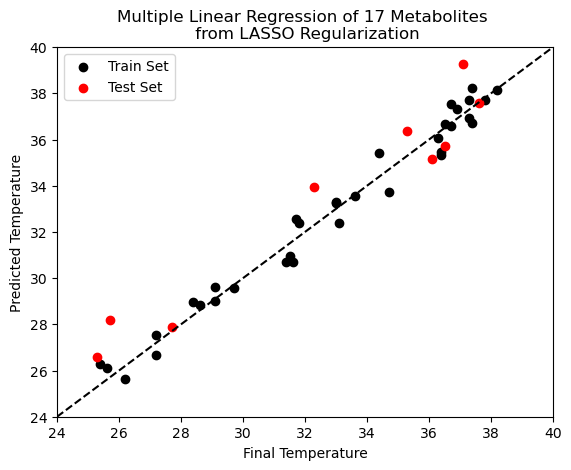

In [36]:
#plotting 
plt.scatter(y_train, y_train_pred,  color='black',label='Train Set')
plt.scatter(y_test, y_test_pred,  color='red',label='Test Set')

plt.title('Multiple Linear Regression of 17 Metabolites \n from LASSO Regularization')
plt.xlabel('Final Temperature') 
plt.ylabel('Predicted Temperature')
# plot diagonal identity line
plt.xlim(24,40)
plt.ylim(24,40)
plt.plot(np.linspace(24,40,100),np.linspace(24,40,100),'k--')
plt.legend()
plt.savefig('../processed_v2/plotReg_MLR-LASSO_trainTest.png')
plt.savefig('../processed_v2/plotReg_MLR-LASSO_trainTest.pdf')
plt.show()

LASSO has better predictive power  of final temperature (compared to univariate correlation)using only 17 metabolites due to lower mean and std. deviation of RMSE values when performing K-Fold cross validation

## Method 3: Partial Least Squares Regression (PLS-R) with Final Temperature as Response Variable
PLSR is supervised regression analysis tool selection tool that performs well when there are many correlated predictor variables, and when there are more features than samples. It is more complicated since it will try to find latent variables useful for the regression problem (similar to finding principal components)

PLSR tutorial: https://www.statology.org/partial-least-squares-in-python/

In [37]:
from sklearn.preprocessing import StandardScaler 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

#Defining Variables:
y = np.array(merged_data['Final_Temp'])
x = np.array(df_metabs)
print(x.shape)

(43, 917)


In [38]:
y

array([36.1, 36.9, 35.3, 36.5, 31.4, 36.4, 27.2, 27.2, 36.4, 25.7, 34.4,
       33.6, 36.3, 36.5, 37.6, 37.4, 31.5, 32.3, 33. , 29.1, 28.4, 25.6,
       36.7, 37.8, 37.3, 31.7, 34.7, 25.3, 29.1, 31.8, 25.4, 26.2, 33. ,
       37.3, 37.4, 37.1, 38.2, 36.7, 27.7, 33.1, 31.6, 28.6, 29.7])

In [39]:
# Define cross-validation method
cv = KFold(n_splits=5, random_state=1,shuffle=True)

# Build multiple linear regression model
model = PLSRegression(n_components=2)

# Use K-fold CV to evaluate model
scores = cross_val_score(model, x, y,
                         scoring='neg_mean_squared_error',
                        cv=cv, n_jobs=1)
# output scores
print(scores)
# Print out the square root of the Mean Squared Error (MSE) 
# for RMSE. 
print('Average RMSE = {}'.format(np.sqrt(np.mean(np.abs(scores)))))
print('Std. Dev of RMSE = {}'.format(np.sqrt(np.std(scores))))

[-4.96149712 -5.27497911 -6.80533658 -3.01491246 -5.46889801]
Average RMSE = 2.2594522914752955
Std. Dev of RMSE = 1.1045182206657422


The PLSR model has greater RMSE compared to the linear regression model that was created using features identified by LASSO regularization. Still, we could perhaps understand what is contributing most to the 2 latent variables that PLS is using

In [40]:
# Create a PLSR model instance, fit to data, and examine loadings
model = PLSRegression(n_components=2)
model.fit(x, y)

# Examine loadings
df_PLSR = pd.DataFrame({'LV_1':model.x_loadings_[:,0],
                       'LV_2':model.x_loadings_[:,0],
                       'LV_1_abs':np.abs(model.x_loadings_[:,0]),
                       'LV_2_abs':np.abs(model.x_loadings_[:,1]),
                      'Distance':np.sqrt(model.x_loadings_[:,0]**2+model.x_loadings_[:,1]**2)})

df_PLSR['CHEMICAL ID']=df_metabs.columns.str.replace('X','').astype(int)
df_PLSR['BIOCHEMICAL'] = df_PLSR['CHEMICAL ID'].map(dict_chemID_BIOCHEMICAL)
df_PLSR['Pathway'] = df_PLSR['CHEMICAL ID'].map(dict_chemID_SUBPATHWAY)


In [41]:
df_PLSR.sort_values(by='Distance',ascending=False).head(20)

,LV_1,LV_2,LV_1_abs,LV_2_abs,Distance,CHEMICAL ID,BIOCHEMICAL,Pathway
247,0.004471,0.004471,0.004471,0.105818,0.105912,100002462,5-(galactosylhydroxy)-L-lysine,Lysine Metabolism
623,0.016568,0.016568,0.016568,0.102805,0.104131,100001293,N-acetylhistidine,Histidine Metabolism
619,-0.008852,-0.008852,0.008852,0.101770,0.102154,1215,N-acetylglucosaminylasparagine,Aminosugar Metabolism
716,0.027976,0.027976,0.027976,0.096813,0.100774,100001416,orotidine,"Pyrimidine Metabolism, Orotate containing"
42,0.014412,0.014412,0.014412,0.096331,0.097403,100009222,1-linoleoyl-2-arachidonoyl-GPE (18:2/20:4)*,Phosphatidylethanolamine (PE)
897,0.006897,0.006897,0.006897,0.095554,0.095803,100021131,undecenoylcarnitine (C11:1),"Fatty Acid Metabolism (Acyl Carnitine, Monouns..."
76,0.009123,0.009123,0.009123,0.094891,0.095328,100008990,1-palmitoyl-2-arachidonoyl-GPE (16:0/20:4)*,Phosphatidylethanolamine (PE)
231,-0.017375,-0.017375,0.017375,0.092825,0.094437,382,3-sulfo-L-alanine,"Methionine, Cysteine, SAM and Taurine Metabolism"
794,-0.004318,-0.004318,0.004318,0.092368,0.092469,100002324,S-carboxymethyl-L-cysteine,Drug - Other
729,0.032618,0.032618,0.032618,0.086352,0.092307,100002107,palmitoyl sphingomyelin (d18:1/16:0),Sphingomyelins


In [42]:
df_PLSR.sort_values(by='Distance',ascending=False).head(20).Pathway.value_counts()

Pathway
Aminosugar Metabolism                                      3
Phosphatidylethanolamine (PE)                              3
Lysine Metabolism                                          2
Histidine Metabolism                                       1
Pyrimidine Metabolism, Orotate containing                  1
Fatty Acid Metabolism (Acyl Carnitine, Monounsaturated)    1
Methionine, Cysteine, SAM and Taurine Metabolism           1
Drug - Other                                               1
Sphingomyelins                                             1
Dihydrosphingomyelins                                      1
Tryptophan Metabolism                                      1
Pyrimidine Metabolism, Uracil containing                   1
Phosphatidylcholine (PC)                                   1
Alanine and Aspartate Metabolism                           1
Phospholipid Metabolism                                    1
Name: count, dtype: int64

# Analyzing Covid19-Su data

(387, 1056)


<Axes: xlabel='percent_missing', ylabel='Count'>

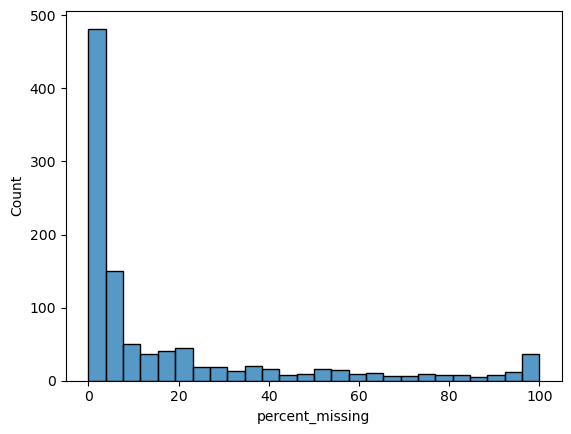

In [43]:
# read in data frame
df_su = pd.read_csv('Su2020_AManalysis_ML.csv')
print(df_su.shape)

# compute percent of missing values per columns
percent_missing = df_su.isnull().sum() * 100 / len(df_su)
missing_value_df = pd.DataFrame({'column_name': df_su.columns,
                                 'percent_missing': percent_missing})
sns.histplot(data=missing_value_df,x='percent_missing')

Based on this, keep features with < 10\% missing values. We can perform median imputation on the rest

In [44]:
threshold = 0.10
# Filter columns with less than 10% missing values
valid_columns = df_su.columns[df_su.isnull().sum()/len(df_su) < threshold]
print(len(valid_columns))
# perform median imputation
df_Su2 = df_su[valid_columns].apply(lambda col: col.fillna(col.median()) if col.dtype in ['float64', 'int64'] else col)
df_Su2.head()

663


,sample_id,Sex,Age,Blood draw time point,Who Ordinal Scale,Covid Status,x_S-1-pyrroline-5-carboxylate,x_1-methylnicotinamide,x_alpha-ketoglutarate,x_kynurenate,...,"x_cis-3,4-methyleneheptanoylglycine","x_bilirubin degradation product, C16H18N2O5 (2)**","x_bilirubin degradation product, C17H18N2O4 (1)**","x_bilirubin degradation product, C17H18N2O4 (2)**","x_bilirubin degradation product, C17H18N2O4 (3)**","x_bilirubin degradation product, C17H20N2O5 (1)**","x_bilirubin degradation product, C17H20N2O5 (2)**",x_tetrahydrocortisol glucuronide,"x_N,N-dimethyl-pro-pro",x_oxindolylalanine
0,1004596,Female,63,T1,0,Healthy,0.780685,0.874071,1.012742,0.881410,...,2.672456,0.971396,1.010499,1.073890,1.133416,0.848404,0.862114,1.318176,0.968010,0.697934
1,1008097,Male,60,T1,0,Healthy,1.015467,1.302361,1.098699,0.944426,...,1.419057,0.931722,1.084651,0.983759,1.044947,0.728484,0.662416,1.308615,1.090740,1.198732
2,1008631,Female,69,T1,0,Healthy,1.093995,0.628660,0.837901,0.688635,...,1.497372,1.228358,0.861357,0.966381,0.977820,1.069649,1.000999,1.360251,0.882618,0.892809
3,1012545,Female,66,T1,0,Healthy,0.603869,2.513620,0.936023,1.094425,...,0.564355,1.745370,1.406997,1.304977,1.200915,1.267855,1.064949,0.538566,1.010964,1.386239
4,1022407,Female,60,T1,0,Healthy,0.699325,1.532138,1.231862,1.202760,...,0.349894,1.173227,1.592433,1.485616,1.468972,1.083740,1.077232,1.308203,0.967860,0.945615


In [45]:
# Let's use PLSregression to transform the data into features that separate mild and severe Covid patients
# keep rows/patients that are mild or severe covid
df_Su3 = df_Su2.loc[df_Su2['Covid Status'].isin(['Mild','Severe'])]
print(df_Su3.shape)

# separate the dataframe into features and y target
metabolites = [col for col in df_Su3.columns if 'x_' in col]
x_Su3 = df_Su3.loc[:,metabolites].values
# Map y variables to 0 and 1
y_Su3 = df_Su3['Covid Status']
y_Su3 = (y_Su3 == 'Severe').astype('int') # 0 for mild, 1 for severe

from sklearn.cross_decomposition import PLSRegression
# Define the PLS regression object
pls_binary =PLSRegression(n_components=3)
# Fit and transform the data
pls_binary.fit(x_Su3, y_Su3)
x_SuPLS = pls_binary.transform(df_Su2.loc[:,metabolites].values)
print(x_SuPLS.shape)

(154, 663)
(387, 3)


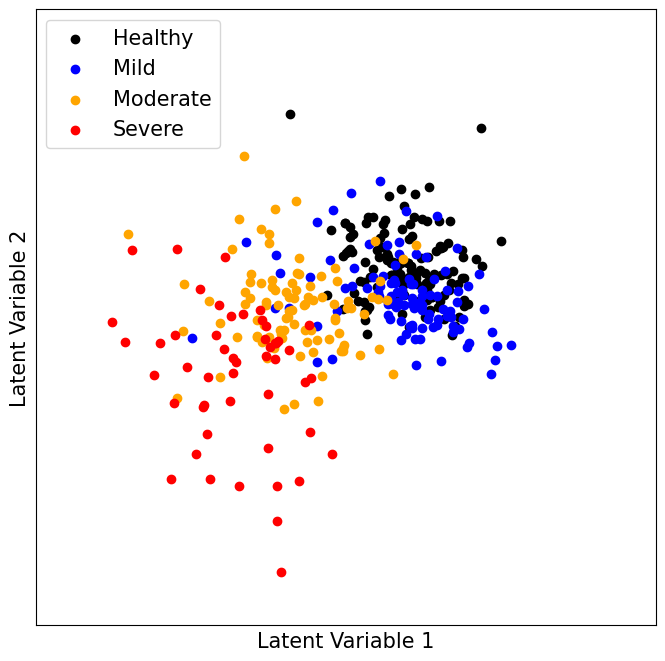

In [46]:
#double check to see proportion of sick vs healthy by sex of mice 
from matplotlib import pyplot as plt

plt.figure(figsize = (8,8))
Groups = ['Healthy','Mild','Moderate','Severe']

colors = ['k','b','orange','r']

for i in range(len(Groups)): 
    Color = colors[i]
    # group = Groups[i]
    
    indicesToKeep = df_Su2[df_Su2['Covid Status'] == Groups[i]].index
    plt.scatter(x_SuPLS[indicesToKeep, 0], x_SuPLS[indicesToKeep, 1]
               , c = colors[i]
               # , s = 400
               # , marker = Marker
               , label = Groups[i], alpha=1)
plt.xlabel('Latent Variable 1',fontsize=15)
plt.ylabel('Latent Variable 2',fontsize=15)
plt.legend(fontsize=15)
plt.xlim(-30,30)
plt.ylim(-20,20)
plt.xticks([])  
plt.yticks([])
plt.savefig('../processed_v2/Covid19-Su_PLS.png')
plt.savefig('../processed_v2/Covid19-Su_PLS.pdf')
plt.show()

In [47]:
df_loadingsPLS = pd.DataFrame({'Metabolite':metabolites,
                               'LV1':pls_binary.x_weights_[:,0],
                              'LV2':pls_binary.x_weights_[:,1],
                               'LV3':pls_binary.x_weights_[:,2]})
df_loadingsPLS['Magnitude'] = np.sqrt(df_loadingsPLS.iloc[:,1]**2+df_loadingsPLS.iloc[:,2]**2+df_loadingsPLS.iloc[:,3]**2)
df_loadingsPLS = df_loadingsPLS.sort_values(by='Magnitude',ascending=False).reset_index(drop=True)
print(df_loadingsPLS.shape)
df_loadingsPLS.to_csv('../processed_v2/df_loadingsPLS.csv')
df_loadingsPLS.head(50)

(657, 5)


,Metabolite,LV1,LV2,LV3,Magnitude
0,x_citrate,0.092530,0.104571,-0.036084,0.144218
1,x_lactosyl-N-palmitoyl-sphingosine (d18:1/16:0),-0.011503,-0.047224,0.127261,0.136227
2,x_1-stearyl-2-docosapentaenoyl-GPC (O-18:0/22:...,0.038385,-0.076666,0.098839,0.130844
3,"x_3,5-dichloro-2,6-dihydroxybenzoic acid",0.035563,0.095126,-0.076445,0.127112
4,x_propionylcarnitine (C3),-0.059206,-0.102937,0.042609,0.126162
5,"x_cis-3,4-methyleneheptanoate",0.014088,0.090383,-0.083481,0.123841
6,x_alpha-ketoglutarate,-0.033380,-0.075389,0.088206,0.120739
7,x_1-palmityl-2-oleoyl-GPC (O-16:0/18:1)*,0.003355,-0.021806,0.115397,0.117488
8,x_beta-hydroxyisovalerate,-0.090936,-0.059282,0.042431,0.116551
9,x_(N(1) + N(8))-acetylspermidine,-0.088917,-0.054118,0.052372,0.116524


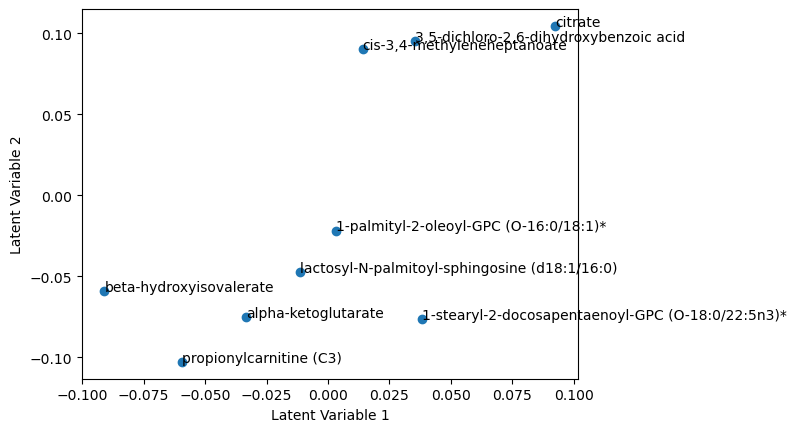

In [48]:
# Visualize loadings
num_points=9
plt.figure()
plt.scatter(df_loadingsPLS.iloc[:num_points,1],df_loadingsPLS.iloc[:num_points,2])
for i in range(num_points):
    plt.annotate(df_loadingsPLS.iloc[i,0].replace('x_',''), 
                 (df_loadingsPLS.iloc[i,1],df_loadingsPLS.iloc[i,2]),
                fontsize=10)
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.savefig('../processed_v2/Covid19-Su_PLS-loadings.png')
plt.savefig('../processed_v2/Covid19-Su_PLS-loadings.pdf')
plt.show()
